# Predicción Multietiqueta con la base de datos *Planet Amazon*

Traducción al español del la [clase de Fast.ai](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb) por [Fernando Bernuy B.](https://scholar.google.cl/citations?user=Q4tEQYYAAAAJ&hl)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Obtener la base de datos

La base de datos *Planet Amazon* no esta disponible en la [página de bases de datos de fast.ai](https://course.fast.ai/datasets) debido a restricciones de derechos de autor, pero puede ser descargado desde [Kaggle](https://www.kaggle.com). Veamos como hacerlo utilizando la [API de Kaggle](https://github.com/Kaggle/kaggle-api), ya que va a ser muy util si quieres participar en una competencia o utilizar otra base de datos disponible en Kaggle.

Lo primero es installar la API de Kaggle descomentando y ejecutando la línea siguiente, o ejecutandola en tu terminal (dependiendo de tu plataforma puedes necesitar modificar levemente este comando para, o incluir algo similar a `source activate fastai`, o agregar una ruta especifica antes del comando `pip`. Mira como `conda install` es llamado en tu plataforma la seccion *Returning to work* de https://course.fast.ai/. Dependiento de tu entorno de desarrollo, puede necesitar agregar `--user` al comando).

In [0]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.5)


Luego debes subir tus credenciales de Kaggle an tu instancia. Ingresa a tu cuenta de Kaggle, luego en tra a la pagina de tu perfil, y en ella a la seccion "My Account". Aqui, busca el botón  llamado "*Create New API Token*" y haz click en él. Esto iniciará la descarga de un archivo llamado "kaggle.json".

Sube este archivo al directorio en el que se esta ejecutando este *notebook* haciendo click en "Upload" en la pagina principal de tu *Jupyter* (o utilizando los comandos para Colab a continuación) y luego ejecuta los comandos de Linux o Windows segun corresponda (si estas utilizando Colab, entonces usa los comandos de Linux).

In [0]:
# ---- Para subir archivo en Colab ----
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
! ls

kaggle.json  sample_data


In [0]:
# ---- Para mover en Linux or Colab ----
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

# ---- Para mover en Windows ----
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

Ya está todo configurado para descargar los datos de la [competencia planet understanding](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). Primero **primero debes ir a su página principal y aceptar sus reglas**, y luego ejecutar las dos celdas siguientes (descomenta los comandos para descargar y descomprimir la data). Si recibes un error `403 forbidden` significa que no has aceptado las reglas de la competencia aún, y debes ir a la pagina de la competencia, hacer click en el tab *Rules* y hacer click en el boton *accept*.

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


Para extraer el contenido de este archivo, vamos a necesitar *7zip*, asi que descomenta la siguiente line si necesitas instalarlo. (o ejecuta `sudo apt install p7zip-full`).

In [0]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

Y ahora podemos descomprimir la base de datos (descomenta para hacerlo, puede tomar algunos minutos)

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

# Clasificación Multietiqueta

Contratrio a a la base de datos de mascotas estudiada en la lección anterior, aqui cada imagen puede tener multiples etiquetas. Si miramos el archivo *csv* que contiene las etiquetas (en `train_v2.csv`) podemos ver que cada `image_name` esta asociada a varias etiquetas separadas por espacios:

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Para incluir esto en un `DataBunch` usando la [API de data block](https://docs.fast.ai/data_block.html) necesitamos usar la clase `ImageList` ( y no la clase `ImageDataBunch`). Esto se asegurará que el modelo creado tendrá la funcion de perdida apropiada para manejar multiples etiquetas.

In [0]:
tfms = get_transforms(flip_vert=True,
                      max_lighting=0.1,
                      max_zoom=1.05,
                      max_warp=0.)

Utilizamos parentesis en torno al *pipeline* (secuencia de procesos) de *data block* para que podamos hacer una declaración de multiples lineas sin tener que agregar `\` al final de cada una.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path,
                          'train_v2.csv',
                          folder='train-jpg',
                          suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` tambien funciona en este caso y nos muestra las diferentes etiquetas saparadas por `;`

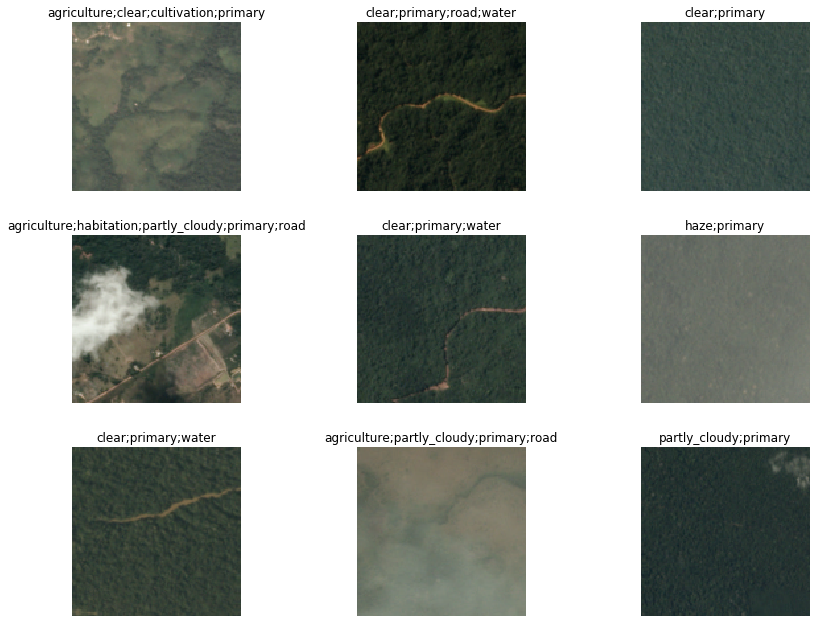

In [0]:
data.show_batch(rows=3, figsize=(12,9))

Para crear un `Learner` utilizamos la misma funcion de la lección 1, y la arquitectura base tambien es `resnet50`, pero las metricas son un poco diferentes: utilizamos `accuracy_thresh` en vez de `accuracy`. En la lección `determinamos la predicción de la clase de una imagen al escoger la activacion final con el valor mas alto, pero aqui cada activacion puede estar entre 0 y 1. `accuract_thresh` elige las clases cuya activacion sea mayor que un sierto umbral (0.5 por defecto) y las compara con el *ground thruth*.

Finalmente, la competencia de Kaggle utiliza la metrica Fbeta (mas detalles [aqui](https://en.wikipedia.org/wiki/F1_score))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Utilizamos el metodo `LR Finder` para encontrar el mejor *learning rate*

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


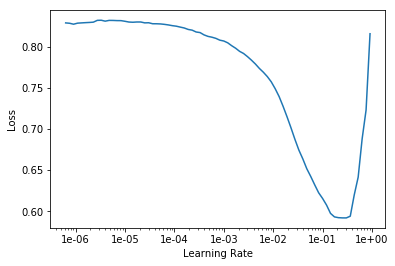

In [0]:
learn.recorder.plot()

Elegimos un *learning rate* apropiado de acuerdo al grafico

In [0]:
lr = 0.01

In [0]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.123708,0.109934,0.948291,0.904464,02:32
1,0.110511,0.096884,0.950761,0.914679,02:31
2,0.099574,0.091734,0.954867,0.920306,02:32
3,0.095136,0.087166,0.956277,0.924480,02:32
4,0.092440,0.086445,0.957258,0.925822,02:32


In [0]:
learn.save('stage-1-rn50')

... y ahora hacemos *fine-tuning* del modelo completo

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


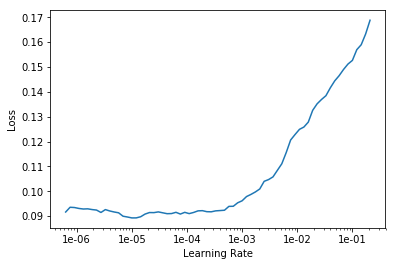

In [0]:
learn.lr_find()
learn.recorder.plot()

nuevamente elegimos un *learning rate* apropiado y volvemos a entrenar

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097105,0.090751,0.950754,0.920825,02:39
1,0.096963,0.089589,0.955383,0.923472,02:40
2,0.089088,0.086144,0.959074,0.926018,02:41
3,0.084086,0.083082,0.957919,0.929640,02:41
4,0.081606,0.082723,0.958362,0.928617,02:41


In [0]:
learn.save('stage-2-rn50')

In [0]:
# learn.load('stage-2-rn50')

Ahora continuaremos el entrenamiento pero utilizaremos un tamaño mayor de la imagen de entrada

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


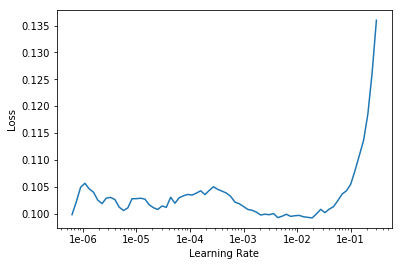

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087132,0.084702,0.956059,0.925059,05:18
1,0.087998,0.083319,0.959053,0.928066,05:17
2,0.084866,0.081876,0.959655,0.930256,05:17
3,0.081673,0.081909,0.960193,0.928967,05:17
4,0.080426,0.080882,0.959401,0.930785,05:17


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
! ls

sample_data


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.082044,0.083117,0.956342,0.926739,07:07
1,0.086245,0.082504,0.958064,0.929781,07:06
2,0.083220,0.082819,0.959278,0.929205,07:07
3,0.079143,0.081002,0.960055,0.930533,07:07
4,0.076605,0.080765,0.959844,0.931821,07:06


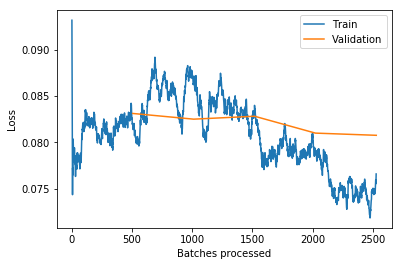

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

En la practica, no podrás saber que tan bien vas hasta que lo hayas enviado a Kaggle, ya que los resultados se miden con una base e datos distinta a la que tenemos para entrenamiento. A modo de referencia, el lugar 50 (de 938 equipos) en el ranking privado tuvo un puntaje de `0.930`.

In [0]:
learn.export()

# FIN
(esta sección será utilizada después, paciencia :) )

In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"